# CxC 2023 -  Intact Challenge
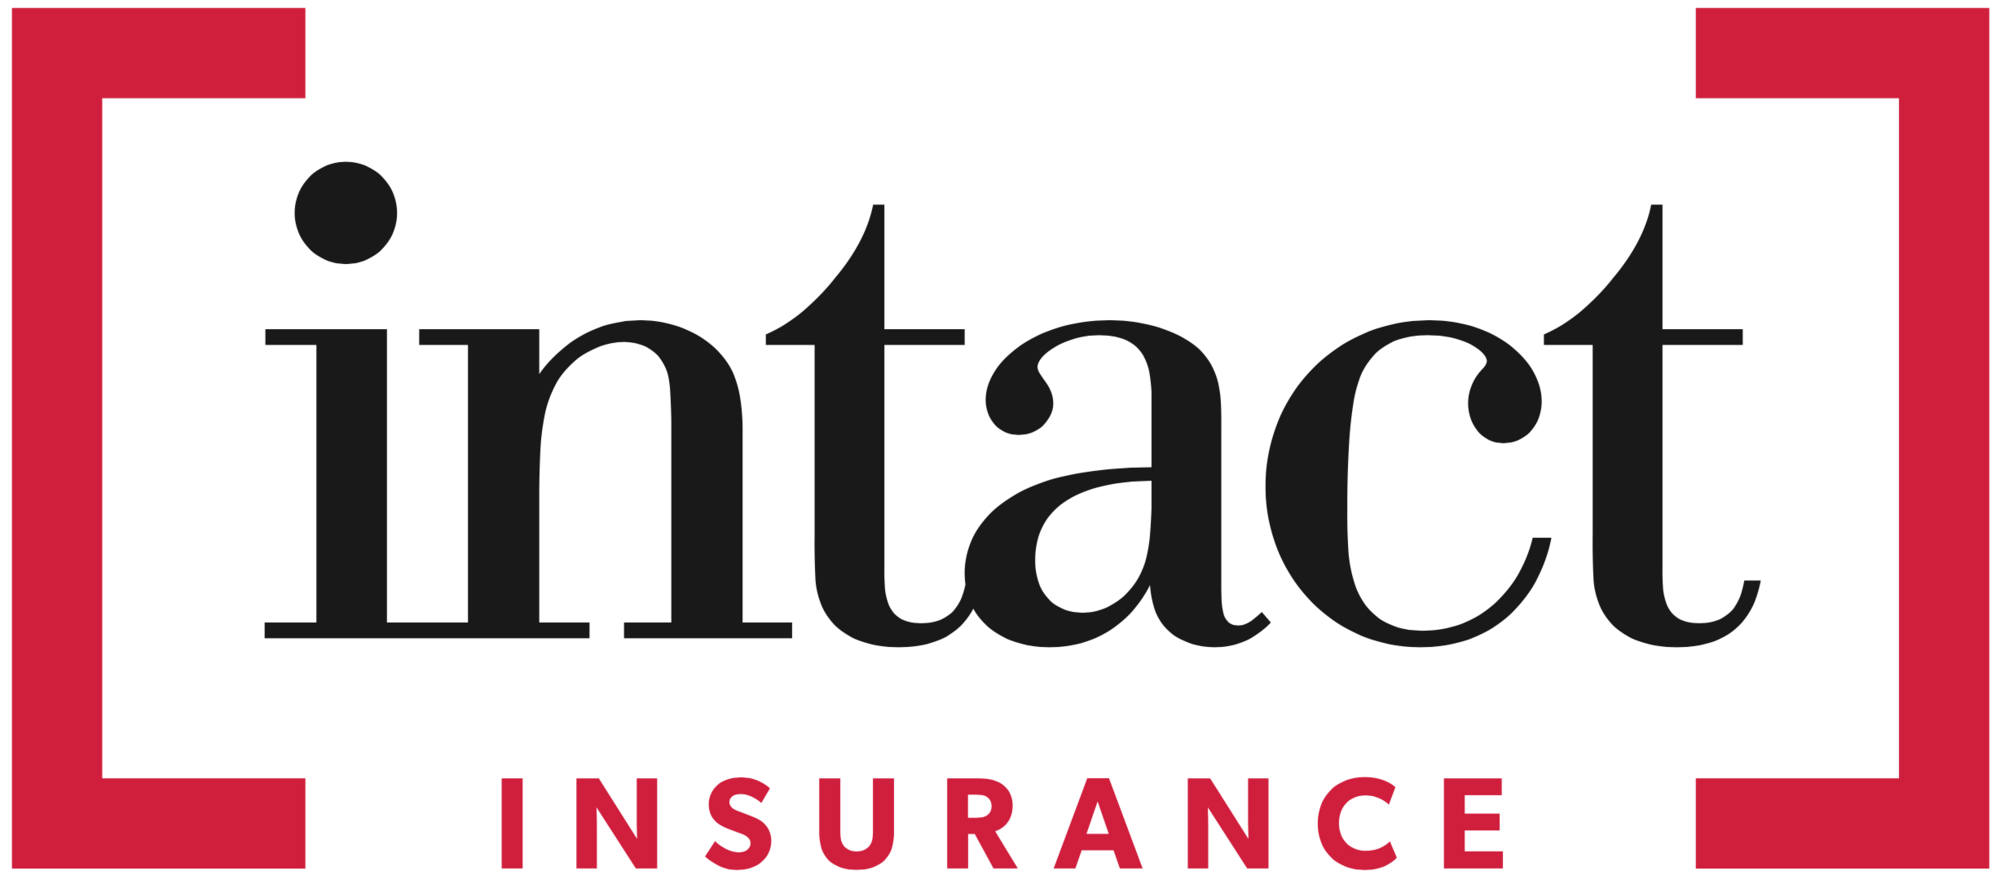

Developed by: Jaden Noronha (j4noronh)

## Table of Contents
*   Introduction
*   Importing Libraries and Data
*   Exploratory Data Analysis
*   Data Preprocessing
*   Model Selection
*   Hyperparameter Tuning
*   Creating the Final Model
*   Conclusion



## Introduction
As Canada's largest P&C insurer, Intact leverages the power of data to address a variety of problems. One such problem is the classification of medical documents into medical specialties. Intact recieves a large number of medical claims on a daily basis that must be managed and sorted in an effective manner to ensure that consumers are recieving their appropriate claims. Machine Learning can be utilized to develop a model that classifies the text from these documents into a medical specialty.

This model was developed using HuggingFace's 'XLNet-base-cased' NLP model, trained on the data provided by Intact. The models were run in a Jupyter Notebook on Google Collab, using a standard GPU hardware accelerator (this model can be run without the accelerator, however it will be **very** slow).

## Importing Libraries and Data

### Downloading required libraries
We first download the libraries that are not already available in Google Collab. The simpletransformers library is based on HuggingFace's transformers library, and provides a simplified method of training and evaluating their NLP models. The optuna library is used to fine-tune the hyperparameters of the XLNet model.

In [1]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.5 MB/s eta 0:00:00


### Importing Libraries
We now import the libraries needed for this model.

In [25]:
# Standard data science libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For text preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# For model creation / Hyperparameter fine-tuning
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler
import sklearn.metrics

# Setting up logs
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Importing Data

In [4]:
data = pd.read_csv('new_train.csv')
data.pop("Unnamed: 0")
data.head()

,medical_specialty,transcription,labels
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1
3,Radiology,"REFERRING DIAGNOSIS: , Motor neuron disease.,P...",2
4,Emergency Room Reports,"CHIEF COMPLAINT: , Dental pain.,HISTORY OF PRE...",0


## Exploratory Data Analysis

### Checking Summary Statistics and Null Values
We note that there are 3969 entries in the training data, and none of the values in the training data are null.

In [13]:
data.describe()

,labels
count,3969.000000
mean,10.078609
std,9.006683
min,0.000000
25%,2.000000
50%,7.000000
75%,16.000000
max,39.000000


In [9]:
data.isnull().sum()

medical_specialty    0
transcription        0
labels               0
dtype: int64

### Analyzing the Frequency of the Transcriptions
We note that the length of the transcriptions are heavily positively skewed, with an average of 3067.8 characters per transcription.

count     3969.000000
mean      3067.837994
std       2031.182363
min         11.000000
25%       1608.000000
50%       2667.000000
75%       4017.000000
max      18425.000000
Name: transcription, dtype: float64

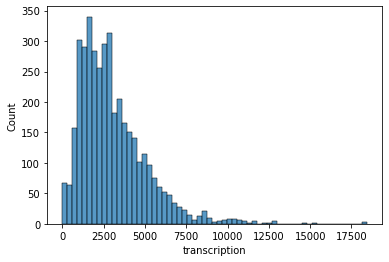

In [8]:
length = data['transcription'].apply(len)
sns.histplot(data=length)
length.describe()

### Analyzing the Frequency of Classes
From the frequency graph below, we note that the classes are extremely unbalanced. There are 40 total classes (from 0 to 39 in the label column), with the most common class being Surgery with 863 and Lab Medicine - Pathology with only 5. This imbalance will significantly hamper the potential of the model. 

With medical documents, there are a variety of terms that can be mentioned depending on the type of document. With such an extreme imbalance, many of the terms that might be used for documents with a lower frequency might not be fully captured in the model. While adding syntetic data, undersampling or oversampling the data might improve this discrepancy, it will still leave out many of the unique terms found in these documents. As such, it is highly recommended to obtain more data points for the infrequent classes as shown below to ensure that the model will be effective. In this model, class weights were used (which will be discussed later).

[Text(0, 0, ' Surgery'),
 Text(1, 0, ' Consult - History and Phy.'),
 Text(2, 0, ' Cardiovascular / Pulmonary'),
 Text(3, 0, ' Orthopedic'),
 Text(4, 0, ' Radiology'),
 Text(5, 0, ' General Medicine'),
 Text(6, 0, ' Gastroenterology'),
 Text(7, 0, ' Neurology'),
 Text(8, 0, ' SOAP / Chart / Progress Notes'),
 Text(9, 0, ' Urology'),
 Text(10, 0, ' Obstetrics / Gynecology'),
 Text(11, 0, ' Discharge Summary'),
 Text(12, 0, ' ENT - Otolaryngology'),
 Text(13, 0, ' Neurosurgery'),
 Text(14, 0, ' Hematology - Oncology'),
 Text(15, 0, ' Ophthalmology'),
 Text(16, 0, ' Emergency Room Reports'),
 Text(17, 0, ' Nephrology'),
 Text(18, 0, ' Pediatrics - Neonatal'),
 Text(19, 0, ' Pain Management'),
 Text(20, 0, ' Psychiatry / Psychology'),
 Text(21, 0, ' Office Notes'),
 Text(22, 0, ' Podiatry'),
 Text(23, 0, ' Dermatology'),
 Text(24, 0, ' Dentistry'),
 Text(25, 0, ' Cosmetic / Plastic Surgery'),
 Text(26, 0, ' Letters'),
 Text(27, 0, ' Endocrinology'),
 Text(28, 0, ' Physical Medicine - Rehab

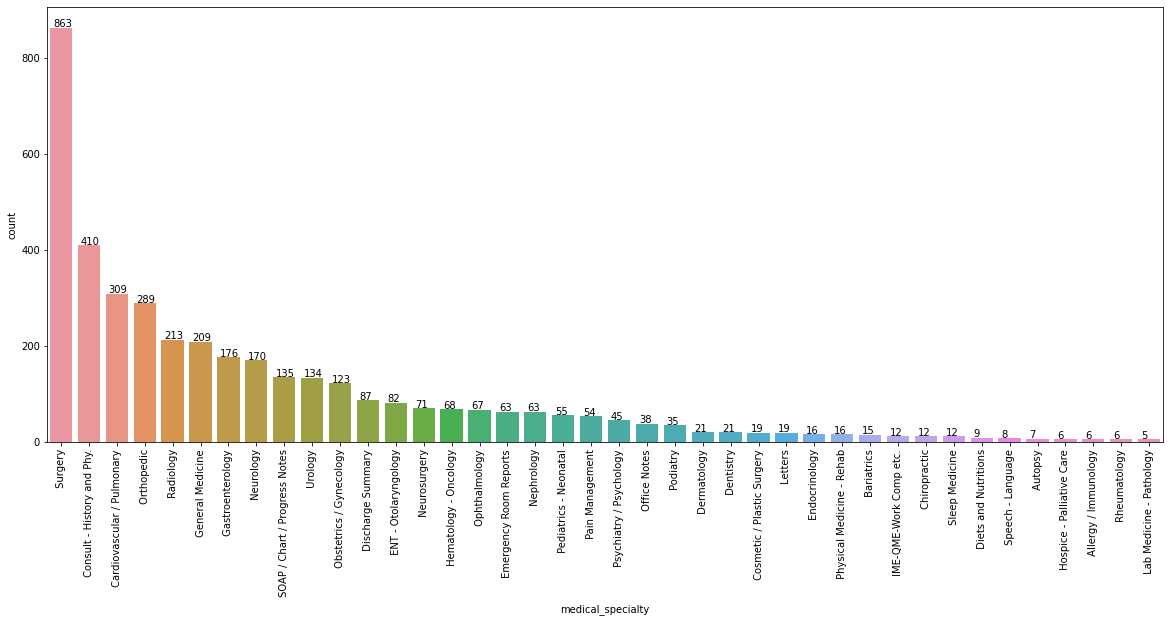

In [14]:
plt.figure(figsize = (20, 8), facecolor = None) 
label_count = sns.countplot(data=data, x='medical_specialty', order=data.medical_specialty.value_counts(ascending=False).index)

for p in label_count.patches:
    height = p.get_height()
    label_count.annotate('{}'.format(height), (p.get_x()+0.11, height+1))

label_count.set_xticklabels(label_count.get_xticklabels(), rotation=90)

## Data Preprocessing
Let us view one of the sample transcripts:

In [22]:
data.head(1).transcription.values[0]

'REASON FOR THE VISIT:,  Very high PT/INR.,HISTORY: , The patient is an 81-year-old lady whom I met last month when she came in with pneumonia and CHF.  She was noticed to be in atrial fibrillation, which is a chronic problem for her.  She did not want to have Coumadin started because she said that she has had it before and the INR has had been very difficult to regulate to the point that it was dangerous, but I convinced her to restart the Coumadin again.  I gave her the Coumadin as an outpatient and then the INR was found to be 12.  So, I told her to come to the emergency room to get vitamin K to reverse the anticoagulation.,PAST MEDICAL HISTORY:,1.  Congestive heart failure.,2.  Renal insufficiency.,3.  Coronary artery disease.,4.  Atrial fibrillation.,5.  COPD.,6.  Recent pneumonia.,7.  Bladder cancer.,8.  History of ruptured colon.,9.  Myocardial infarction.,10.  Hernia repair.,11.  Colon resection.,12.  Carpal tunnel repair.,13.  Knee surgery.,MEDICATIONS:,1.  Coumadin.,2.  Simva

There are a lot of elements in this transcript that are unneccessart and could impact the preformance of the model. First, there are many stopwords, such as 'the', 'is' and 'an'. Stopwords are words that are extremely common in the english language, and are unneccessary when training our model. Additionally, there is a lot of punctuation and spacing that is not required. To address this, we will preprocess the text using a function.

Note that the function also has inputs for stemming (removing suffixes and prefixes from words) and lemmatizing (reducing words into their base form). During our tests, we discovered that enabling these features harmed the preformance of our model, but future iterations might benefit from using them.

In [23]:
def text_process(mess, stem = False, lem = False):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Remove all numbers
    4. Remove all words with character len <= 2
    5. If stem = True, Stem the words
    6. If lem = True, Lemmanize the words
    """
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    # Check characters to see if they are in punctuation
    nopunc = [char.lower() if char not in string.punctuation else ' ' for char in mess]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Remove any stopwords, numbers and strings with less than 3 characters
    words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and not word.isnumeric() and len(word) > 2]
    
    # Stem the words
    if stem:
      stemmed_words = []
      for word in words:
        stemmed_words.append(stemmer.stem(word))
      words = stemmed_words

    # Lemmatize the words
    if lem:
      lemmed_words = []
      for word in words:
        lemmed_words.append(lemmatizer.lemmatize(word))
      words = lemmed_words
    
    return words

In [24]:
data['clean_text'] = data['transcription'].apply(text_process)
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(x))
data.head()

,medical_specialty,transcription,labels,clean_text
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0,reason visit high inr history patient year old...
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1,preoperative diagnosis acetabular fracture lef...
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1,name procedure selective coronary angiography ...
3,Radiology,"REFERRING DIAGNOSIS: , Motor neuron disease.,P...",2,referring diagnosis motor neuron disease perti...
4,Emergency Room Reports,"CHIEF COMPLAINT: , Dental pain.,HISTORY OF PRE...",0,chief complaint dental pain history present il...


Now let us visualize the cleaned text using a word cloud. While there are still some words that are not super specific, such as well and old, most of the unneccesary elements in the raw transcriptions have been removed.

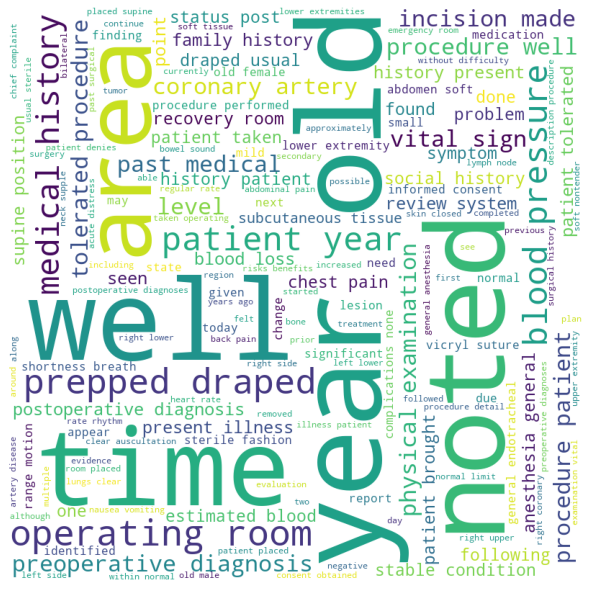

In [27]:
text = " ".join(review for review in data['clean_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

## Model Selection
We will be using HuggingFace's XLNet NLP model, more specifically 'xlnet-base-cased' as the basis for our classification model. While other NLP models exist, such as BERT and roBERTa, we found that XLNet preformed the best and was the most stable when training and testing. 

To make the training process easier, we will use the SimpleTransformers library, which is based on HuggingFace's own Transformers model. This library will streamline the training and testing process. Future iterations can use the Transformers library for more granular control over the training of the model.


### Creating the Train/Validation Split
We will now split the cleaned data into a training and validation set, with an 80%/20% split. The X values will be the clean_text column containing the processed transcription data, and the y values will be the labels column. The split will be stratified to ensure the proportion of classes in the training and test data are consistent. However, due to the aformentioned class discrepancies, these sets will be imbalanced.

In [28]:
X, y = data['clean_text'], data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14, stratify=y)

### Determining the weights of the training data
To mitigate the imbalance, we will be assigning weights to the classes. To calculate the weights, we used the inverse frequency ranking (the frequency of the most frequent class / the frequency of the current class) squared. This was to ensure that any key features from the minority classes were amplified.

In [29]:
weights = y_train.value_counts().reset_index().sort_values('index')
weights['rel_weight'] = (weights.labels.max() / weights.labels)**2
weights

,index,labels,rel_weight
17,0,50,190.440000
0,1,690,1.000000
4,2,170,16.474048
22,3,28,607.270408
7,4,136,25.740701
6,5,141,23.947488
3,6,231,8.922247
2,7,247,7.803767
16,8,50,190.440000
12,9,66,109.297521


## Hyperparameter Tuning
We will now use the Optuna library to determine the optimal hyperparameters of an XLNet model using our data. The training was done on Google Collab, and due to the platform's limitations, only a limited set of hyperparameters could be used for tuning. These parameters were:
*   num_train_epochs (from 4 to 6): The number of Epochs used when training the model.
*   learning_rate (from 0.00001 to 0.001): The learning rate of the model
*   train_batch_size (8, 16, 32, 64): The number of examples in a batch when training.

The effectiveness of a model was determined using its f1_macro score. The optimizer utilized Bayesian optimization to determine the best parameters in a more efficient manner.

The final parameters were {'num_train_epochs': 6, 'learning_rate': 3.084172179226037e-05, 'train_batch_size': 16} with an f1_macro score of 0.182


In [7]:
def objective(trial):
    # Define hyperparameters to optimize
    hyperparameters = { # chosen due to environment limitations
        'num_train_epochs': trial.suggest_int('num_train_epochs', 4, 6),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
        'train_batch_size': trial.suggest_categorical('train_batch_size', [8, 16, 32, 64]),
        'overwrite_output_dir': True
    }

    # Train SimpleTransformers model with hyperparameters
    class_weights = dict(zip(weights.index, np.array(weights.rel_weight, dtype=float)))
    model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=40, args=hyperparameters)
    model.train_model(pd.DataFrame(pd.concat([X_train,y_train], axis=1)), sample_weight=np.array([class_weights[y_i] for y_i in y_train]))

    # Evaluate SimpleTransformers model on validation data
    pred, model_outputs = model.predict(list(X_test.values))

    return sklearn.metrics.f1_score(y_test,pred, average='macro')


In [8]:
sampler = TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=25)
best_hyperparameters = study.best_params
print('Best Hyperparameters:', best_hyperparameters)

[I 2023-02-24 22:18:45,699] A new study created in memory with name: no-name-1316b5af-3dc1-45a3-89bc-2735955a6c52


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:22:47,071] Trial 0 finished with value: 0.08226854125045172 and parameters: {'num_train_epochs': 4, 'learning_rate': 1.0938316435811205e-05, 'train_batch_size': 16}. Best is trial 0 with value: 0.08226854125045172.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:27:38,324] Trial 1 finished with value: 0.008954451345755694 and parameters: {'num_train_epochs': 4, 'learning_rate': 9.435028462664567e-05, 'train_batch_size': 8}. Best is trial 0 with value: 0.08226854125045172.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and 

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:33:06,211] Trial 2 finished with value: 0.008945191313340227 and parameters: {'num_train_epochs': 6, 'learning_rate': 0.0005179746363093499, 'train_batch_size': 16}. Best is trial 0 with value: 0.08226854125045172.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:36:52,223] Trial 3 finished with value: 0.09852216022493955 and parameters: {'num_train_epochs': 4, 'learning_rate': 2.06930550613399e-05, 'train_batch_size': 16}. Best is trial 3 with value: 0.09852216022493955.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:41:47,753] Trial 4 finished with value: 0.11939103534892581 and parameters: {'num_train_epochs': 4, 'learning_rate': 1.4719948367335903e-05, 'train_batch_size': 8}. Best is trial 4 with value: 0.11939103534892581.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and 

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:45:48,877] Trial 5 finished with value: 0.008945191313340227 and parameters: {'num_train_epochs': 5, 'learning_rate': 0.000496544293427981, 'train_batch_size': 64}. Best is trial 4 with value: 0.11939103534892581.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and 

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:51:17,802] Trial 6 finished with value: 0.1489602135560455 and parameters: {'num_train_epochs': 6, 'learning_rate': 4.743600424979335e-05, 'train_batch_size': 16}. Best is trial 6 with value: 0.1489602135560455.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and ar

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 22:54:39,525] Trial 7 finished with value: 0.11211487324338668 and parameters: {'num_train_epochs': 4, 'learning_rate': 4.352466269204648e-05, 'train_batch_size': 64}. Best is trial 6 with value: 0.1489602135560455.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/397 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/397 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:02:00,435] Trial 8 finished with value: 0.02283990604992992 and parameters: {'num_train_epochs': 6, 'learning_rate': 0.00013293441241925424, 'train_batch_size': 8}. Best is trial 6 with value: 0.1489602135560455.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:07:31,174] Trial 9 finished with value: 0.12903406027361197 and parameters: {'num_train_epochs': 6, 'learning_rate': 1.3359039922860741e-05, 'train_batch_size': 16}. Best is trial 6 with value: 0.1489602135560455.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and 

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:11:39,441] Trial 10 finished with value: 0.12250635336825881 and parameters: {'num_train_epochs': 5, 'learning_rate': 3.996430082902366e-05, 'train_batch_size': 32}. Best is trial 6 with value: 0.1489602135560455.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and 

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:17:12,292] Trial 11 finished with value: 0.11570447087093012 and parameters: {'num_train_epochs': 6, 'learning_rate': 1.0467447381787258e-05, 'train_batch_size': 16}. Best is trial 6 with value: 0.1489602135560455.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:22:42,952] Trial 12 finished with value: 0.18236350816907482 and parameters: {'num_train_epochs': 6, 'learning_rate': 3.084172179226037e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:26:54,260] Trial 13 finished with value: 0.14351707120656748 and parameters: {'num_train_epochs': 5, 'learning_rate': 3.290184273390841e-05, 'train_batch_size': 32}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:32:24,872] Trial 14 finished with value: 0.055014317410477756 and parameters: {'num_train_epochs': 6, 'learning_rate': 7.87759236626822e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:37:58,413] Trial 15 finished with value: 0.16215479266061208 and parameters: {'num_train_epochs': 6, 'learning_rate': 2.456783996269179e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:42:36,677] Trial 16 finished with value: 0.1363995868111984 and parameters: {'num_train_epochs': 5, 'learning_rate': 2.4484114352491257e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:47:31,350] Trial 17 finished with value: 0.12679945343427387 and parameters: {'num_train_epochs': 6, 'learning_rate': 2.1645434724971445e-05, 'train_batch_size': 32}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:51:38,469] Trial 18 finished with value: 0.12262867274099398 and parameters: {'num_train_epochs': 5, 'learning_rate': 5.6486032450413485e-05, 'train_batch_size': 64}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-24 23:57:09,132] Trial 19 finished with value: 0.021645946928389677 and parameters: {'num_train_epochs': 6, 'learning_rate': 0.00015805055904823042, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased 

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-25 00:01:47,927] Trial 20 finished with value: 0.12356658153506346 and parameters: {'num_train_epochs': 5, 'learning_rate': 2.584918591293681e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-25 00:07:19,080] Trial 21 finished with value: 0.17361043857492547 and parameters: {'num_train_epochs': 6, 'learning_rate': 5.3102939473457254e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-25 00:12:55,047] Trial 22 finished with value: 0.15959827760768158 and parameters: {'num_train_epochs': 6, 'learning_rate': 6.553385354015919e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased an

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-25 00:18:28,211] Trial 23 finished with value: 0.17519310645044767 and parameters: {'num_train_epochs': 6, 'learning_rate': 2.9881392485665673e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased a

  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-02-25 00:24:01,649] Trial 24 finished with value: 0.1442986034616483 and parameters: {'num_train_epochs': 6, 'learning_rate': 3.568673843460771e-05, 'train_batch_size': 16}. Best is trial 12 with value: 0.18236350816907482.


Best Hyperparameters: {'num_train_epochs': 6, 'learning_rate': 3.084172179226037e-05, 'train_batch_size': 16}


## Creating the Final Model
Now that we have the expected optimal parameters, we can develop and train our final model.

In [36]:
# Create a ClassificationModel
model_final = ClassificationModel(
    'xlnet',
    'xlnet-base-cased',
    num_labels=40,
    args={'num_train_epochs': 6, 'learning_rate': 3.084172179226037e-05, 'train_batch_size': 16,  'overwrite_output_dir': True}
    # use_cuda = False (Use this line if running on CPU only, where CUDA cores are not available)
) 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [37]:
X, y = data['clean_text'], data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14, stratify=y)

# Train the model
class_weights = dict(zip(weights.index, np.array(weights.rel_weight, dtype=float)))
model_final.train_model(pd.DataFrame(pd.concat([X_train,y_train], axis=1)), sample_weight=np.array([class_weights[y_i] for y_i in y_train]))

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3175 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/199 [00:00<?, ?it/s]

(1194, 1.8791634504319834)

After training the model, we can measure its f1_score against the validation data:

In [38]:
pred, model_outputs = model_final.predict(list(X_test.values))
sklearn.metrics.f1_score(y_test,pred, average='macro')

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.15519848074828585

We note that the actual f1_macro value was significantly lower than the expected value. This could be due to random attributes during the optuna optimization process.

### Predicting the classes for the test data
Now that we have a model, we can predict the classes for the test data.

In [42]:
test_data = pd.read_csv('new_test.csv')

final_pred, _ = model_final.predict(list(test_data.transcription.values))
test_data['predictions'] = final_pred

test_data.pop('Unnamed: 0')
test_data.pop('transcription')
test_data.head()

  0%|          | 0/997 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

,predictions
0,6
1,16
2,7
3,1
4,5


Finally, we export these predictions as a csv file:

In [44]:
test_data.to_csv('j4noronh_Intact_predictions.csv')
from google.colab import files
files.download('j4noronh_Intact_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion
We have developed a model to classify medical documents using XLNet as our base NLP model. While this model is a good start, there were many setbacks that we encountered during the development process:
*   The data was extremely imbalanced. Due to the nature of different medical documents, the extremely imbalanced training dataset omitted many terms that could exist in these documents. While preprocessing the transcripts and weighing the classes helped emphasize the underrepresented classes, the model will greatly benefit from more samples in the underrepresented classes.
*   Optuna was inconsistent. The hyperparameters used in the optimizer yeilded a different f1_macro score than the final model when being judged against the validation data. Simpletransformers is better optimized for Wandb (another hyperparameter tuning library), however the library ran into many issues with Google Collab, mainly when using a GPU/TPU accelerator. When switching to a CPU backend without using CUDA cores, it ran at an extremely slow pace which led to the optimizer being timed out.
*   Google Collab was limited in its capabilities. The model was trained on Google Collab with additional computing cores. Due to the limitations in RAM and storage, the ammount of training that could be preformed was severely limited. The hyperparameters that were optimized using Optuna had to be significantly restricted to ensure that it could run on the limited hardware available. Additionally, Google Collab timed out often, meaning that most of the training steps in this notebook had to be repeated. We did try using Azure Notebooks, however there was a compatability issue that prevented the easytransformer library from being imported.

